# Brain Tumor Detection

![](notebook_images/notebook.png)

---
Magnetic Resonance Imaging (MRI) scans are considered the best tool for analyzing tumors in the brain. "Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor... A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties" ([Kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)). 

The purpose of this project will be to deploy a deep learning model that can accurately classify MRI brain tumor images into four different categories:
- Glioma - a tumor made of astrocytes that occurs in the brain and spinal cord
- Meningioma - a usually noncancerous tumor that arises from the membranes surrounding the brain and spinal cord.
- None - no tumor present in brain. 
- Pituitary - a tumor that forms in the pituitary gland near the brain that can change hormone levels.

*Data originally came from [Kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri) but was cloned from the original [GitHub Repo](https://github.com/sartajbhuvaji/brain-tumor-classification-dataset) containing the images for easy of use.*


In [2]:
!pip3 install --upgrade tensorflow # needed for tf.data.AUTOTUNE (SageMaker uses 2.1.3, we need 2.4.1)

In [4]:
pip install -U sagemaker # update sagemaker to 2.3.5

In [6]:
pip install tdqm

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os 
import time
import platform
import tqdm

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score

import sagemaker
from sagemaker.tensorflow import TensorFlow, TensorFlowModel

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

print(f'TensorFlow Version: {tf.__version__}')
print(f'SageMaker Version: {sagemaker.__version__}')
print(f'Python Version: {platform.python_version()}')

TensorFlow Version: 2.4.1
SageMaker Version: 2.38.0
Python Version: 3.6.13


## Loading Images

Although the data is seperated into training and testing directories, and th subdirectories contain the labels for the images, we won't be using the data_from_directory function. Data will be loaded from the subdirectories, put into numpy arrays, and combined together for all classes in both training and testing data (in seperate arrays). We will use [OpenCV](https://docs.opencv.org/master/) to read in and resize the images, then returning a tuple with the loaded image and its corresponding labels.

In [2]:
def load_images(main_dir, sub_dir):
    '''
    Using OpenCV, load the images for a directory and return the image/label as a tuple. 
    Image will be resized to 224x224. Filenames will also be returned to be used 
    for plotting loaded images against filenames to make sure they were correctly loaded and labeled.
    '''
    filenames = glob.glob(f'{main_dir}/{sub_dir}/*.jpg')
    assert len(filenames) == len(os.listdir(f'{main_dir}/{sub_dir}')) # make sure all images loaded
    x = np.array([cv2.resize(cv2.imread(fname), (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA) for fname in filenames])
    y = np.array([sub_dir] * len(filenames)) # create labels for images (sub directory name)
    assert len(x) == len(y) # make sure each image has a label
    return x, y, filenames    

#### Training Images

In [68]:
img_type = 'Training'
sub_dir_names = next(os.walk(img_type))[1] # get training subdirectories
start = time.time() # start time

# create initial arrays for first subdirectory
x_train, y_train, filenames_train = load_images(img_type, sub_dir_names[0])
print(f'Successfully loaded {sub_dir_names[0]} directory.')

# concatenate remaining subdirectories to the above arrays
for sub_dir in sub_dir_names[1:4]:
    x_tmp, y_tmp, filenames_tmp = load_images(img_type, sub_dir)
    x_train = np.concatenate([x_train, x_tmp], axis=0)
    y_train = np.concatenate([y_train, y_tmp], axis=0)
    filenames_train = np.concatenate([filenames_train, filenames_tmp], axis=0)
    print(f'Successfully loaded {sub_dir} directory.')
    
print(f'\nLoaded {len(x_train)} {img_type} images in {round(time.time() - start, 3)} seconds.') # 2870 total training images

Successfully loaded no_tumor directory.
Successfully loaded pituitary_tumor directory.
Successfully loaded glioma_tumor directory.
Successfully loaded meningioma_tumor directory.

Loaded 2870 Training images in 23.335 seconds.


Class Label: glioma_tumor


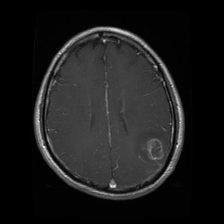

In [5]:
idx = 1438

print(f'Class Label: {y_train[idx]}') # Get image label
array_to_img(x_train[idx, :, :, :]) # Visualize loaded image

True Label: glioma_tumor


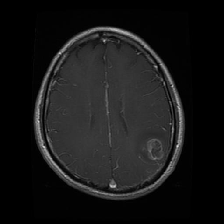

In [6]:
file_label = filenames_train[idx].split('/')[1]
print(f'True Label: {file_label}') # Get directory name (true label)
load_img(filenames_train[idx], target_size=(IMG_SIZE, IMG_SIZE)) # Get directory image (match above?) 

For the training data, we seem to have around half as many observations for *no_tumor* compared to the other classes, but this should not be too large of an issue. The remainig classes seem to be balanced with around 800 observations each. For testing data, our classes seem to be mostly balanced (no extreme difference between max and min observations). 

## Image Preprocessing
Now that we have our data loaded and stored in their corresponding arrays, we will want to create a validation set (using 20% of the training data). We will also want to create tf Datasets from these arrays (images and labels) in order to augment and normalize the images. *Note that training images with be augmented, while validation/testing will only be normalized.* 

After creating these datasets, we will want to convert them into TFRecord files (for training and validation) so they can be uploaded to S3. Note that test images can be left in tf Dataset format since it will be used within the notebook on the deployed model.

In [69]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=42)
filenames_train = None

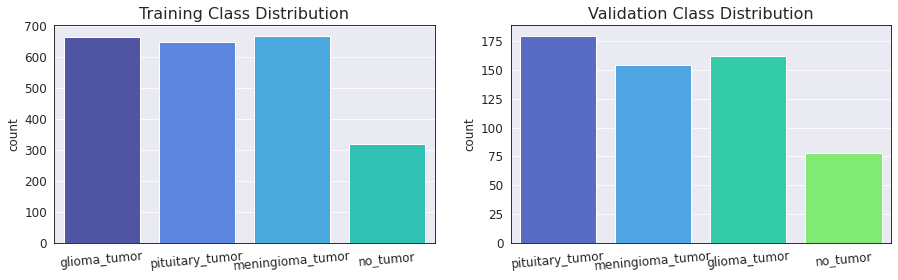

In [8]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,2,1)
sns.countplot(x=y_train, palette=sns.color_palette('turbo', 12))
plt.title('Training Class Distribution')
plt.xticks(rotation=5)
ax2 = plt.subplot(1,2,2)
sns.countplot(x=y_val, palette=sns.color_palette('turbo', 8))
plt.title('Validation Class Distribution')
plt.xticks(rotation=5)
plt.show();

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [13]:
def cast(image, label):
    image = tf.convert_to_tensor(image, dtype=tf.uint8) # convert to tensor
    return image, label

def train_augment(image, label):
    seed = np.random.randint(1, 150, size=1)[0]
    image = tf.convert_to_tensor(image, dtype=tf.uint8) # convert to tensor
    image = tf.image.random_flip_up_down(image, seed=seed) # random flip
    image = tf.image.random_flip_left_right(image, seed=seed) # random flip
    return image, label

In [14]:
train_dataset = (
    train_dataset
    .map(train_augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    .shuffle(buffer_size=len(X_train))
)
print('Train Dataset Augmented')

val_dataset = (
    val_dataset
    .map(cast, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
print('Validation Dataset Normalized')

Train Dataset Augmented
Validation Dataset Normalized


In [15]:
def show_images(image_iterator):
    plt.figure(figsize=(15, 10))
    idx = 0
    for image, label in image_iterator:
        ax = plt.subplot(5, 5, idx+1)
        plt.imshow(image)
        plt.title(label.decode('UTF-8'))
        plt.axis("off")
        idx += 1
        if idx == 25:
            break

In [16]:
tmp = None
for img, lbl in train_dataset.as_numpy_iterator():
    tmp = img
    break

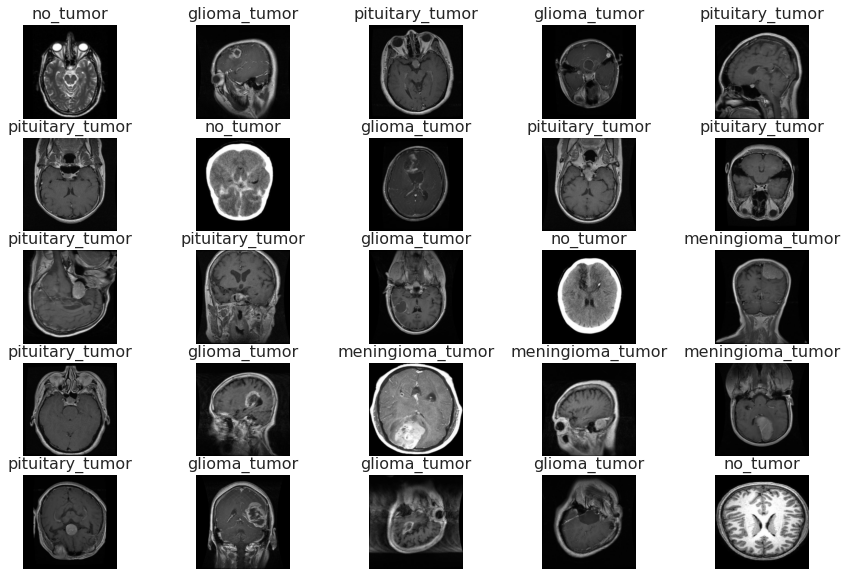

In [18]:
show_images(train_dataset.as_numpy_iterator())

### TFRecord Conversion
Since SageMaker requires us to upload data to S3 in order to be used for our model, we will want to convert our Dataset into a TFRecord file. Using the conversion functions (byte, float, int) come from the [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data) on reading/writing image data, we will serialize our data and write it to a TFRecord file. We will also read the dataset and display the image/label to ensure the data is properly stored.

In [21]:
labels = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'no_tumor': 2,
    'pituitary_tumor': 3
}

string_labels = {v: k for k, v in labels.items()} # map one-hot-encoded label to string label

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [30]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def tf_image_format(image, label):
    feature = {
        'label': _int64_feature(labels[label.decode('UTF-8')]), # labels is dict containing one-hot-encoding mapping
        'image_raw': _bytes_feature(tf.io.serialize_tensor(image))
    }
    return tf.train.Example(features = tf.train.Features(feature=feature))

def _parse_image_function(image):
    return tf.io.parse_single_example(image, image_feature_description)

In [23]:
train_record_file = 'train_images.tfrecords'

with tf.io.TFRecordWriter(train_record_file) as writer:
    for image, label in train_dataset.as_numpy_iterator():
        tf_example = tf_image_format(image, label)
        writer.write(tf_example.SerializeToString())

In [24]:
val_record_file = 'val_images.tfrecords'

with tf.io.TFRecordWriter(val_record_file) as writer:
    for image, label in val_dataset.as_numpy_iterator():
        tf_example = tf_image_format(image, label)
        writer.write(tf_example.SerializeToString())

In [25]:
tmp_label = None
tmp_img_decoded = None

tf_record_train_data = tf.data.TFRecordDataset(train_record_file) # 'raw_data/train_images.tfrecords'
tfr_train_dataset = tf_record_train_data.map(_parse_image_function)

# Get first image and label from training dataset
for img_features in tfr_train_dataset:
    tmp_label = img_features['label'].numpy()
    tmp_img_decoded = tf.io.parse_tensor(img_features['image_raw'], out_type=tf.uint8).numpy()
    break

1 : meningioma_tumor


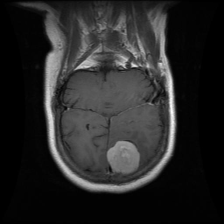

In [26]:
print(tmp_label, ':', string_labels[tmp_label])
array_to_img(tmp_img_decoded)

We now have tfrecords files containing all of our training (1.38 GB) and validation (346 MB) images. Note that we do not need to do this to our test set since the model will be deployed/tested within this notebook (no need to upload to S3). Now that we have our record files, we can upload our training and validation sets to S3 in order to be used in our model. 

**IMPORTANT**: We will have to add the parse and decode function to our python file containing our model.

### Upload Data to S3
Now that we have our TFRecord files, we want to upload our data to S3 to be used for training and validation. We will be using [Pipe Mode](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#training-with-pipe-mode-using-pipemodedataset), a built in function from SageMaker that allows our data to be in TFRecord format and be streamed directly to our model. See the *entry_point* python file that contains the model to see how the data is being loaded and formatted from the TFRecord file into the PipeModeDataset.

In [27]:
# Move tfrecords to raw data directory (upload entire directory to S3)
os.rename('train_images.tfrecords', 'raw_data/train_images.tfrecords')
os.rename('val_images.tfrecords', 'raw_data/val_images.tfrecords')

In [3]:
data_dir = 'raw_data'
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix='sagemaker/mri_images'
role = sagemaker.get_execution_role()

In [29]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Modeling

We will now create our TensorFlow model using Transfer Learning. The model script will be located in the **scipts/train.py** file, containing the model and data creation. We will want to create a SageMaker TensorFlow object in order to train the model, as well deploying the trained model to be used on the testing data.

In [52]:
# Create directory for storing training script
script_dir = 'scripts'
if not os.path.exists(script_dir):
    os.makedirs(script_dir)

In [32]:
!pygmentize scripts/train.py

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import argparse
import os
import json
AUTOTUNE = tf.data.AUTOTUNE
TRAIN_BUFFER = 2296

from model import EfficientNetClassifier

def tfrecord_reader(record):
    '''
    Parse a single tfrecord and return the image (formatted as a tensor)
    and the label (formatted as an integer).
    '''
    features = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    
    parsed = tf.io.parse_single_example(record, features)
    label = tf.cast(parsed['label'], tf.int32)
    return tf.io.parse_tensor(parsed['image_raw'], tf.uint8), tf.one_hot(label, 4)

def load_data(data_dir):
    '''
    Create a TFRecordDataset and decode a given tfrecord file.
    '''
    data = tf.data.TFRecordDataset(data_dir)
    data = data.map(tfrecord_reader)
    return data

def create_dataset(data_dir, BATCH_SIZE, train=False):
    '

#### Create Class Weights

Since we do have an imbalance in our classes (around half the amount of *no_tumor* compared to the otehr 3 classes) we will want to create class weights in order to make sure our model learns from all classes and does not pay less attention to the minority class.

In [36]:
# Create weights and save to current directory
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
np.save('class_weights.npy', weights)
print(weights)

[0.86445783 0.85928144 1.81072555 0.88717156]


In [37]:
# Upload saved weights to S3
weights_dir = 'class_weights'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)
os.rename('class_weights.npy', f'{weights_dir}/class_weights.npy')
_ = sagemaker_session.upload_data(path=weights_dir, bucket=bucket, key_prefix=prefix)

### Training the Model

Above is the Python file containing our model. We will now want to create our SageMaker TensorFlow object and begin training. We will pass the batch size and number of epochs below, then train/validate the model.

In [38]:
input_path = f's3://{bucket}/{prefix}'
print(input_path)

s3://sagemaker-us-west-2-274875039787/sagemaker/mri_images


In [39]:
!pygmentize scripts/model.py

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
IMG_SIZE = 224

def EfficientNetClassifier():
    '''
    Using transfer learning, create an EfficientNetB0 model to be used. We
    will update the output for the model as well as unfreeze some of the final
    15 layers to be trainined and learn more low level features in our images.
    '''
    effnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model = layers.GlobalAveragePooling2D()(effnetb0.output)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(4, activation='softmax')(model)
    model = models.Model(inputs=effnetb0.input, outputs=model)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    


In [40]:
estimator = TensorFlow(entry_point='train.py',
                       source_dir='scripts',
                       role=role,
                       instance_count=1,
                       instance_type='ml.p2.xlarge',
                       framework_version='2.4.1',
                       py_version='py37',
                       hyperparameters={
                           'batch_size':32,
                           'epochs':25
                       })

In [41]:
estimator.fit({'training': input_path})

2021-04-19 22:42:05 Starting - Starting the training job...
2021-04-19 22:42:29 Starting - Launching requested ML instancesProfilerReport-1618872125: InProgress
......
2021-04-19 22:43:35 Starting - Preparing the instances for training............
2021-04-19 22:45:36 Downloading - Downloading input data
2021-04-19 22:45:36 Training - Downloading the training image...............
2021-04-19 22:48:07 Training - Training image download completed. Training in progress..2021-04-19 22:48:08.946937: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-04-19 22:48:08.953202: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-04-19 22:48:09.076549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-19 22:48:09.195717: W tensorflow

72/72 - 69s - loss: 0.3865 - accuracy: 0.8510 - val_loss: 2.0840 - val_accuracy: 0.6237
Epoch 2/25
72/72 - 40s - loss: 0.1228 - accuracy: 0.9525 - val_loss: 1.5454 - val_accuracy: 0.6690
Epoch 3/25
72/72 - 40s - loss: 0.1286 - accuracy: 0.9564 - val_loss: 0.4650 - val_accuracy: 0.8641
Epoch 4/25
72/72 - 40s - loss: 0.0684 - accuracy: 0.9747 - val_loss: 0.7740 - val_accuracy: 0.7787
Epoch 5/25
72/72 - 40s - loss: 0.0766 - accuracy: 0.9743 - val_loss: 0.9311 - val_accuracy: 0.6568

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/25
72/72 - 40s - loss: 0.0267 - accuracy: 0.9952 - val_loss: 0.5175 - val_accuracy: 0.7962
Epoch 7/25
72/72 - 40s - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.3166 - val_accuracy: 0.8711
Epoch 8/25
72/72 - 40s - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.2241 - val_accuracy: 0.9181
Epoch 9/25
72/72 - 40s - loss: 0.0115 - accuracy: 0.9978 - val_loss: 0.0618 - val_accuracy: 0.9721
Epoch 10/25
72/72 - 40s - loss: 0.0054

### Deploy the Model

Now that we have our model trained, we will load the model artifacts from S3 since training and deployment will be handled at different times. We will load the above model and deploy it to predict on the testing images, which will also need to be loaded and formatted to be predicted on.

In [3]:
img_type = 'Testing'
sub_dir_names = next(os.walk(img_type))[1] # get training subdirectories
start = time.time() # start time

# create initial arrays for first subdirectory
x_test, y_test, filenames_test = load_images(img_type, sub_dir_names[0])
print(f'Successfully loaded {sub_dir_names[0]} directory.')

# concatenate remaining subdirectories to the above arrays
for sub_dir in sub_dir_names[1:4]:
    x_tmp, y_tmp, filenames_tmp = load_images(img_type, sub_dir)
    x_test = np.concatenate([x_test, x_tmp], axis=0)
    y_test = np.concatenate([y_test, y_tmp], axis=0)
    filenames_test = np.concatenate([filenames_test, filenames_tmp], axis=0)
    print(f'Successfully loaded {sub_dir} directory.')
    
print(f'\nLoaded {len(x_test)} {img_type} images in {round(time.time() - start, 3)} seconds.') # 394 total testing images

Successfully loaded no_tumor directory.
Successfully loaded pituitary_tumor directory.
Successfully loaded glioma_tumor directory.
Successfully loaded meningioma_tumor directory.

Loaded 394 Testing images in 3.618 seconds.


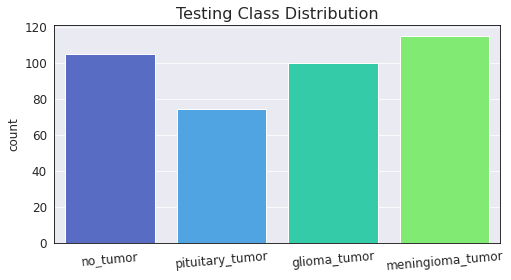

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(x=y_test, palette=sns.color_palette('turbo', 8))
plt.title('Testing Class Distribution')
plt.xticks(rotation=5)
plt.show()

In [4]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [6]:
model_path = f's3://{bucket}/tensorflow-training-2021-04-19-22-42-05-451/output/model.tar.gz'
model_path

's3://sagemaker-us-west-2-274875039787/tensorflow-training-2021-04-19-22-42-05-451/output/model.tar.gz'

In [13]:
loaded_model = TensorFlowModel(model_data=model_path, role=role, framework_version='2.4.1')

predictor = loaded_model.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------------------!

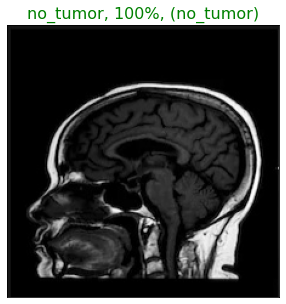

In [35]:
labels = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'no_tumor': 2,
    'pituitary_tumor': 3
}

string_labels = {v: k for k, v in labels.items()}

def process_image(image):
    image = tf.expand_dims(image, 0)
    input_data = {'instances': np.asarray(image)}
    return input_data

def show_image(image, y_pred, y_test, probs):
    plt.figure(figsize=(5,5))
    color = 'red' 
    if y_pred == y_test: # green if correct
        color = 'green'
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}, {:2.0f}%, ({})'.format(y_pred, probs*100, y_test), fontdict={'color':color})
    plt.show();


input_data = process_image(x_test[1])
y_pred = predictor.predict(input_data)
y_pred_label = string_labels[np.argmax(y_pred['predictions'][0])]
show_image(x_test[1], y_pred_label, y_test[1], max(y_pred['predictions'][0]))

In [47]:
def predict_test_data(test_img):
    '''
    Loop through testing data, sending each image to the deployed
    endpoint and returning a list of predicted labels and probabilities.
    '''
    preds = []
    probs = []
    for img in tqdm.tqdm(test_img):
        input_data = process_image(img)
        y_pred = predictor.predict(input_data)
        probs.append(max(y_pred['predictions'][0]))
        preds.append(string_labels[np.argmax(y_pred['predictions'][0])])
    
    return preds, probs

In [76]:
y_preds, y_probs = predict_test_data(x_test)

100%|██████████| 394/394 [01:00<00:00,  6.50it/s]


In [30]:
results_df = pd.DataFrame({'Probability': y_probs,
                           'Predicted Class': y_preds,
                           'True Class': y_test,
                           'Correct': [1 if (pred_label == true_label) else 0 
                                       for pred_label, true_label in zip(y_preds, y_test)]})
results_df.head()

,Probability,Predicted Class,True Class,Correct
0,0.999985,no_tumor,no_tumor,1
1,0.999785,no_tumor,no_tumor,1
2,0.999999,no_tumor,no_tumor,1
3,0.999977,no_tumor,no_tumor,1
4,0.999941,no_tumor,no_tumor,1


In [31]:
results_df.to_csv('test_results/results.csv', index=False) # save to test results directory

Testing Accuracy: 73.86%


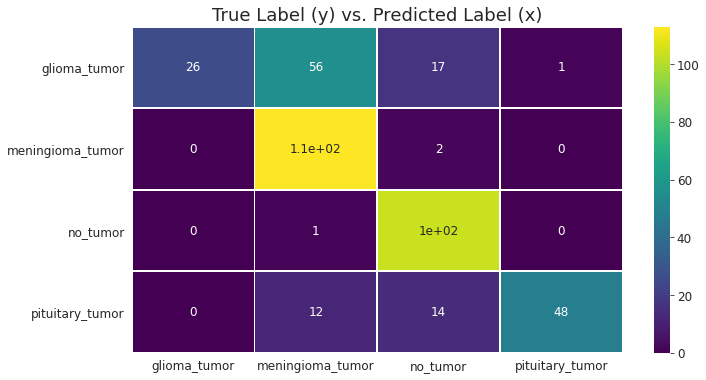

In [25]:
print(f'Testing Accuracy: {round(accuracy_score(y_test, y_preds)*100, 2)}%')

cmatrix = confusion_matrix(y_test, y_preds)
cmat_labels = list(labels.keys())

plt.figure(figsize=(11,6))
sns.heatmap(cmatrix, cmap='viridis', linewidth=0.8, annot=True, 
            xticklabels = cmat_labels, yticklabels= cmat_labels)
plt.title('True Label (y) vs. Predicted Label (x)', fontdict={'fontsize':18})
plt.show()

From the above confusion matrix, we can see that the majority of the issue seems to be with glioma and pituitary tumors. They both seem to be getting classified incorrectly as meningioma and no_tumor. But meningioma and no_tumor seem to be performing almost perfectly with only 1 or 2 incorrectly classified images. This leads me to beleive either our model is not fitting well to the two incorrect classes, or there is an issue with the labeling/images in the test set. Looking at other people's results, they also seem to be getting much worse results in the test set compared to the training set. 

In [80]:
predictor.delete_endpoint() # delete the endpoint

#### Investigating Misclassified Images & Probabilities

From other notebooks that I've seen, people seem to be getting a test accuracy ranging from 30% to 60% (so I guess our model seems to be performing well). But we will want to look further into what is causing the misclassification.

*NOTE:* when predicting on the validation set using the endpoint, we still got accuracy around 99%. So there could be an issue with the labeling for test images or possibly similar images in the train dataset that caused overfitting.

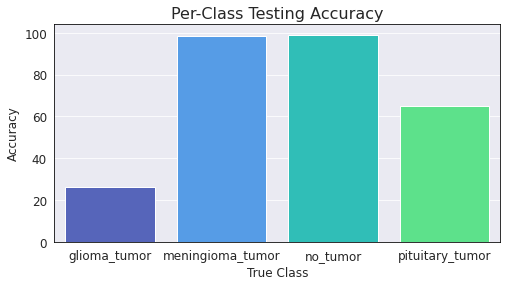

In [68]:
plt.figure(figsize=(8,4))
tmp = results_df.groupby('True Class')['Correct'].agg('sum')/results_df.groupby('True Class')['Correct'].agg('count')
sns.barplot(x=tmp.index, y=tmp.values*100, palette=sns.color_palette('turbo', 9))
plt.ylabel('Accuracy')
plt.title('Per-Class Testing Accuracy')
plt.show();

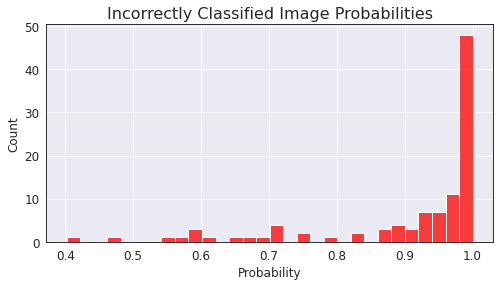

In [75]:
plt.figure(figsize=(8,4))
sns.histplot(results_df[results_df['Correct'] == 0]['Probability'], bins=30, color='red')
plt.title('Incorrectly Classified Image Probabilities')
plt.show();

We seem to be getting around 100% accuracy for both meningioma and no tumor classes. However, pituitary hs around 65% accuracy and glioma has around 25% accuracy. On top of this, most the the misclassified images seem to have high prediction probabilities associated with them (90%+). Again, since other people were getting similar/worse results from test data but similar on training/validation, it leads me to think that there could be an issue with the test labels for glioma and pituitary. 

## Resources

The following is a list of resources used for this project:
- [Train a TensorFlow Model in Amazon SageMaker ](https://towardsdatascience.com/train-a-tensorflow-model-in-amazon-sagemaker-e2df9b036a8)  Jun M.
- [TensorFlow Documentation for TFRecord and Image Data](https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data)
- [How to train an Image Classifier on TFRecord files](https://towardsdatascience.com/how-to-train-an-image-classifier-on-tfrecord-files-97a98a6a1d7a) - Karan Sindwani
- [Working with TFRecords and tf.train.Example](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d) - Cihan Soylu
- [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)  - Keras API